# Challenge 0

In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')
sys.version

'3.6.5 (default, Jun 17 2018, 12:15:43) \n[GCC 4.2.1 Compatible Apple LLVM 8.0.0 (clang-800.0.42.1)]'

In [2]:
! pip freeze
! pip --version

certifi==2018.8.24
dill==0.2.8.2
pip 18.0 from /Users/ibrahimmuhammad/miniconda3/envs/py35/lib/python3.5/site-packages/pip (python 3.5)


In [3]:
!# curl -O https://challenge.blob.core.windows.net/challengefiles/gear_images.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33.4M  100 33.4M    0     0  4972k      0  0:00:06  0:00:06 --:--:-- 6069k


# Challenge 1

https://customvision.ai/projects/095eac50-bf07-4100-8352-80ff06aee711#/performance

In [4]:
import requests

def predict(image_url):
    prediction_url = 'https://southcentralus.api.cognitive.microsoft.com/customvision/v2.0/Prediction/095eac50-bf07-4100-8352-80ff06aee711/url?iterationId=2d6a978e-d4a6-4770-ba4b-9529224b5cc1'
    data = {"Url": image_url}
    headers = {
        'Prediction-Key': 'a99c55c1f6a740c3862bb1ffba0d3d4c',
        'Content-Type': 'application/json'
    }

    response = requests.post(prediction_url, json=data, headers=headers)
    return response.json()

In [5]:
from pprint import pprint
pprint(predict('https://image.sportsmansguide.com/adimgs/l/6/673942i3_ts.jpg'))

{'created': '2018-10-03T18:07:32.3836664Z',
 'id': '68890d6b-1341-4a98-93a5-eafa650f64f5',
 'iteration': '2d6a978e-d4a6-4770-ba4b-9529224b5cc1',
 'predictions': [{'probability': 1.0,
                  'tagId': 'a91fc173-47bc-4d62-b395-4295884004a3',
                  'tagName': 'insulated_jacket'},
                 {'probability': 7.454575e-21,
                  'tagId': 'f6010827-8174-4eb6-8523-f1d4b913318e',
                  'tagName': 'hardshell_jacket'}],
 'project': '095eac50-bf07-4100-8352-80ff06aee711'}


# Challenge 2

In [40]:
def equalize(image):
    streched_img = skimage.exposure.equalize_adapthist(image, clip_limit=0.0)
    img_min = streched_img.min()
    img_max = streched_img.max()
    return ((streched_img - img_min) / (img_max - img_min) * 255).astype(np.uint8)

In [41]:
import numpy as np
import skimage.io
import skimage.util
import skimage.exposure
import skimage.transform
import matplotlib.pyplot as plt

IMAGE_SIZE = 128
N_CHANNELS = 3

def pad(image):
    h, w, c = image.shape
    delta = abs(h - w)
    if h > w:
        return skimage.util.pad(image, ((0, 0), (delta//2, delta//2), (0, 0)), 'constant', constant_values=255)
    elif w > h:
        return skimage.util.pad(image, ((delta//2, delta//2), (0, 0), (0, 0)), 'constant', constant_values=255)
    else:
        return image
    
def preprocess(img):
    padded_img = pad(img)
    equalized_img = equalize(padded_img)
    resized_img = skimage.transform.resize(equalized_img, (IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS), preserve_range=True)
    return resized_img.astype('uint8')
    
filename = 'data/input/insulated_jackets/10312601x1128398_zm.jpeg'
img = skimage.io.imread(filename)
preprocessed_img = preprocess(img)

(400, 366, 3)
(128, 128, 3)


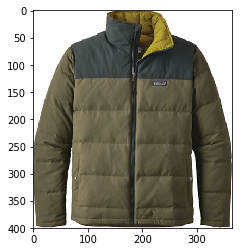

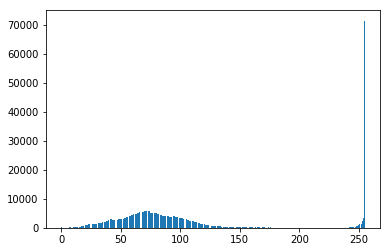

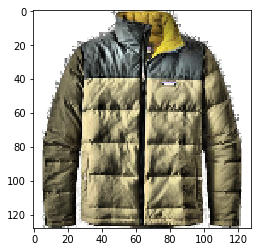

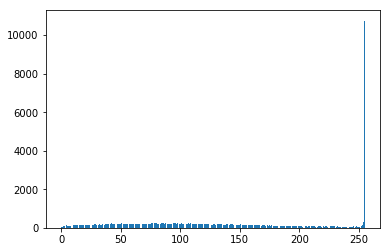

In [42]:
def inspect_image(img):
    plt.figure()
    plt.imshow(img, vmin=0, vmax=255)
    print(img.shape)
    y, x = skimage.exposure.histogram(img)
    plt.figure()
    plt.bar(x , y)
    
inspect_image(img)
inspect_image(preprocess(img))

In [74]:
import glob
import tqdm

INPUT_PATH = 'data/input/**/**'

def load_data_from_path(image_path):

    preprocessed_images = []
    labels = []

    image_files = glob.glob(image_path)
    
    for filename in tqdm.tqdm(image_files):
        label = filename.split('/')[2]
        img = skimage.io.imread(filename)
        preprocessed_img = preprocess(img)
        labels.append(label)
        preprocessed_images.append(preprocessed_img)
    
    return preprocessed_images, labels

preprocessed_images, labels = load_data_from_path(INPUT_PATH)

100%|██████████| 2122/2122 [03:34<00:00,  9.88it/s]


axes


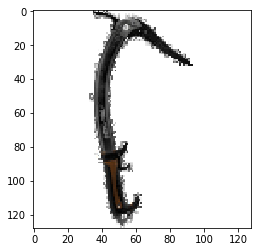

In [75]:
i=5
plt.imshow(preprocessed_images[i])
print(labels[i])

In [76]:
np.save('data/preprocessed/x_train.npy', np.array(preprocessed_images))
np.save('data/preprocessed/y_train.npy', np.array(labels))

In [78]:
print('X train shape:', np.array(preprocessed_images).shape)
print('y train shape:', np.array(labels).shape)

X train shape: (2122, 128, 128, 3)
y train shape: (2122,)


In [79]:
X_test_raw, y_test_raw = load_data_from_path('data/test/**/*')
np.save('data/preprocessed/x_test.npy', X_test_raw)
np.save('data/preprocessed/y_test.npy', y_test_raw)

100%|██████████| 241/241 [00:11<00:00, 20.45it/s]


# Challenge 3

In [80]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt

In [95]:
X_train_raw = np.load('data/preprocessed/x_train.npy')
y_train_raw = np.load('data/preprocessed/y_train.npy')
X_test_raw = np.load('data/preprocessed/x_test.npy')
X_train_raw = np.load('data/preprocessed/x_train.npy')

In [84]:
classes = list(set(y_train_raw))
print('Classes:', classes)
print('Number of classes', len(classes))

Classes: ['gloves', 'carabiners', 'rope', 'harnesses', 'pulleys', 'insulated_jackets', 'tents', 'axes', 'hardshell_jackets', 'boots', 'helmets', 'crampons']
Number of classes 12


In [85]:
np.array(X_train_raw).shape

(2122, 128, 128, 3)

In [96]:
def get_classifer_input(x_train_raw, y_train_raw):
    X_train = np.array(x_train_raw).reshape((-1, 128*128*3))
    y_train = np.array([classes.index(label) for label in y_train_raw])
    return X_train, y_train

X_train, y_train = get_classifer_input(X_train_raw, y_train_raw)
X_test, y_test = get_classifer_input(X_test_raw, y_test_raw)

In [87]:
X_train_raw[0].shape

(128, 128, 3)

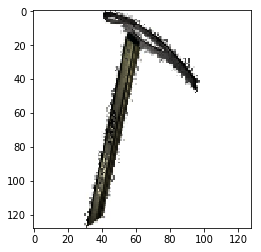

In [88]:
plt.imshow(X_train[2].reshape((128, 128, 3)))

In [89]:
np.bincount(y_train)

array([215, 262, 194, 185,  42, 240, 117,  79, 459, 116,  95, 118])

In [90]:
y_train_raw

array(['axes', 'axes', 'axes', ..., 'tents', 'tents', 'tents'],
      dtype='<U17')

In [91]:
classes[y_train[2]]

'axes'

In [92]:
print('Preprocessed images shape:', np.array(preprocessed_images).shape)
print('X_train shape', X_train.shape)
print('X_train min', X_train.min())
print('X_train max', X_train.max())
print('y_train min', y_train.min())
print('y_train max', y_train.max())

Preprocessed images shape: (2122, 128, 128, 3)
X_train shape (2122, 49152)
X_train min 0
X_train max 255
y_train min 0
y_train max 11


In [102]:
clf = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)

In [115]:
clf = RandomForestClassifier(class_weight='balanced', n_jobs=-1, n_estimators=5000, warm_start=True)

In [219]:
clf = SVC(gamma='auto', verbose=1)

In [53]:
clf = GradientBoostingClassifier(n_estimators=10, learning_rate=5.0, verbose=1, warm_start=True)

In [ ]:
clf.fit(X_train, y_train)

In [97]:
print('X_test shape', X_test.shape)
print('X_test min', X_test.min())
print('X_test max', X_test.max())
print('y_test min', y_test.min())
print('y_test max', y_test.max())

X_test shape (241, 49152)
X_test min 0
X_test max 255
y_test min 0
y_test max 11


In [109]:
y_pred = clf.predict(X_test)

In [114]:
#y_pred_train = clf.predict(X_train)

[[23  0  0  0  0  0  0  0  0  0  0  1]
 [ 0 29  0  0  0  0  0  1  0  0  0  0]
 [ 2  0 14  0  0  1  0  1  2  1  1  0]
 [ 3  0  0 17  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  1  0  0  0  3  0  0  1]
 [ 0  0  0  0  0 11  0  0 16  0  0  0]
 [ 0  0  0  0  0  0 14  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  9  0  0  0  0]
 [22  0  5  0  0  1  0  0 23  0  0  0]
 [ 1  0  0  0  0  0  0  0  0 12  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 11  0]
 [ 0  0  0  0  0  0  0  1  0  0  0 13]]


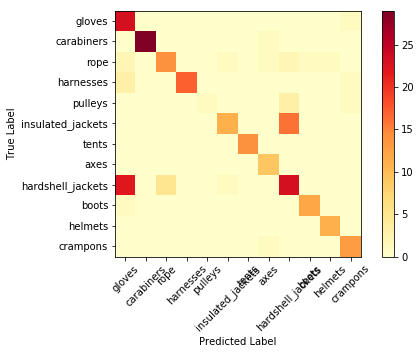

In [110]:
# Define a plotting function confusion matrices 
#  (from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, target_names, title = 'The Confusion Matrix', cmap = plt.cm.YlOrRd):
    plt.figure()
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.tight_layout()
    
    # Add feature labels to x and y axes
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    plt.colorbar()
    
cm = confusion_matrix(y_test, y_pred)
#cm2 = confusion_matrix(y_train, y_pred_train)
# Actual counts
print(cm)

# Visually inpsect how the classifier did of matching predictions to true labels
plot_confusion_matrix(cm, classes)
#plot_confusion_matrix(cm2, classes)

In [116]:
clf.score(X_test, y_test)

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [62]:
clf.score(X_train, y_train)

0.05466540999057493

In [161]:
TEST_IMAGE = 'data/ae42ad29e70ba8ce6b67d3bdb6ab5c6e.jpeg'
helmet = 'data/input/helmets/110031.jpeg'
rope = 'data/input/rope/110338.jpeg'

def predict(filename):
    test_img = preprocess(skimage.io.imread(filename))
    y_pred = clf.predict(test_img.reshape(1, -1))
    return classes[y_pred[0]]
    
print(predict(TEST_IMAGE))
print(predict(rope))
print(predict(helmet))

tents
tents
tents


# Challenge 4

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Challenge 5

# Challenge 6

In [ ]:
import dill
dill.dump_session('notebook_env.db')
dill.load_session('notebook_env.db')